In [1]:
# %matplotlib widget 

%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy

import warnings
warnings.filterwarnings("ignore")

sc.settings.verbosity = 0

In [3]:
try:
    from sys import path as syspath
    from os import path as ospath
    syspath.append(ospath.join(ospath.expanduser("~"), 'Documents/git/Xct'))

    from scTenifoldXct.main import *
    import scTenifoldXct.dNN as dNN    
    import scTenifoldXct.visualization as vis
    
except ImportError:
    print('Module not found')

In [4]:
ada = sc.read_h5ad("../data/heart_global_processed_v3.h5ad") #after QC, downsample and HVG
ada

AnnData object with n_obs × n_vars = 9199 × 3000
    obs: 'cell_type', 'ident'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    uns: 'ident_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'log1p', 'raw'
    obsp: 'connectivities', 'distances'

In [5]:
ada.raw.X.shape
#del ada.raw

(9199, 33538)

In [6]:
ada.obs['ident'].value_counts()

EC             1245
NK              911
CD8+T_cytox     896
LYVE1+MA1       762
CD16+Mo         690
CD8+T_tem       650
FB              470
DOCK4+MA1       452
LYVE1+MA3       397
CD4+T_cytox     382
DOCK4+MA2       377
MA_mod          273
Mast            250
NKT             248
B_cells         231
Mo_pi           213
CD4+T_tem       207
LYVE1+MA2       204
MA_AgP          182
DC              155
IL17RA+Mo         4
Name: ident, dtype: int64

In [ ]:
# import numpy.core.defchararray as np_f

# ada.obs['ident'] = np_f.replace(np.asarray(ada.obs['cell_states'], dtype=str), 'Ø', 'A')
# ada.obs['ident'] = ada.obs['ident'].astype('category')
# ada.obs['ident'].value_counts()

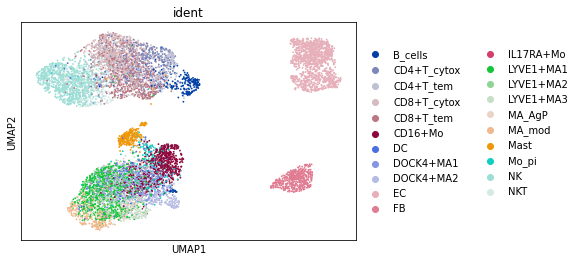

In [7]:
sc.pl.umap(ada, color='ident')

## create a Xct_metrics obj:

In [8]:
heart = Xct_metrics(ada)
type(heart)

scTenifoldXct.main.Xct_metrics

In [9]:
heart._genes_index_DB

array([[1188,    0],
       [2209, 2074],
       [2502, 2074],
       ...,
       [   0,    0],
       [   0,    0],
       [   0, 1506]])

In [10]:
id1 = heart._genes_index_DB[0, 0]
ada.var_names[id1-1] #check

'BDNF'

## create a Xct obj with GRN building:

In [11]:
# obj1 = Xct(ada, 'FB', 'MA_AgP', build_GRN = True, save_GRN = True, 
#           pcNet_name = 'Net_FB2MA_AgP', mode = 'full', verbose=True)

obj1 = Xct(ada, 'FB', 'MA_AgP', build_GRN = False, 
           pcNet_name = 'Net_FB2MA_AgP', verbose=True)
print(obj1)

init an Xct object for interactions from FB (470) to MA_AgP (182)...
loading GRNs...
building correspondence...
init completed.

Xct object for interactions from FB (470) to MA_AgP (182)
# of genes = 3000 X 3000 
Correspondence = 6000 X 6000


In [12]:
df1 = obj1.fill_metric()
len(df1)

771

## mode 'full':

In [13]:
obj1._net_A.shape, obj1._net_B.shape, obj1._w.shape #check

((3000, 3000), (3000, 3000), (6000, 6000))

In [14]:
w12 = obj1._w[:obj1._net_A.shape[0], obj1._net_A.shape[1]:]

np.mean(w12) # check scale 

1.0011323276879665

In [15]:
#selected LR pairs
candidates = get_candidates(df1)
print(len(candidates))
candidates[:5]

771


['CXCL12_GNAI2', 'PTPN6_EPO', 'IL1B_EPO', 'LGALS1_PTPRC', 'IL1B_PLAUR']

In [16]:
counts_np1 = get_counts_np(obj1)
len(counts_np1), counts_np1[0].shape, counts_np1[1].shape

(2, (3000, 470), (3000, 182))

In [29]:
projections, losses = dNN.train_and_project(counts_np1, w = obj1._w, dim = 3, steps = 1500, lr = 0.01)

Net(
  (linear1): Linear(in_features=470, out_features=148, bias=True)
  (linear2): Linear(in_features=148, out_features=37, bias=True)
  (linear3): Linear(in_features=37, out_features=3, bias=True)
)
Net(
  (linear1): Linear(in_features=182, out_features=92, bias=True)
  (linear2): Linear(in_features=92, out_features=23, bias=True)
  (linear3): Linear(in_features=23, out_features=3, bias=True)
)
1 19112.197265625
10 9669.8095703125
20 5852.43505859375
30 4454.771484375
40 4123.36962890625
50 4135.513671875
60 4082.482666015625
70 4048.674560546875
80 4038.610595703125
90 4027.546630859375
100 4018.77685546875
110 4010.241455078125
120 4001.46533203125
130 3992.58251953125
140 3983.171630859375
150 3973.18701171875
160 3962.55712890625
170 3951.716064453125
180 3941.474365234375
190 3932.42529296875
200 3924.544921875
210 4383.697265625
220 4050.521240234375
230 3982.941650390625
240 3958.32177734375
250 3940.31591796875
260 3928.165283203125
270 3918.239990234375
280 3910.8955078125
2

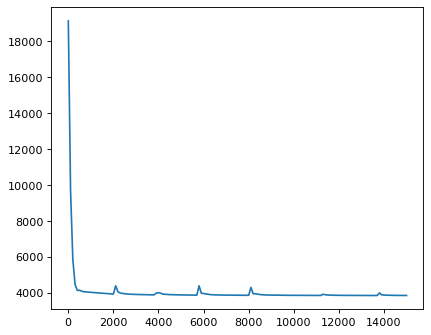

In [30]:
plot_nn_loss(losses)

In [31]:
df_nn = nn_aligned_dist(obj1, projections)
df_nn

computing pair-wise euclidean distances...
adding column 'correspondence'...


,ligand,receptor,dist,correspondence
CFHR3_CFHR3,CFHR3,CFHR3,0.038187,0.000000
CFHR3_FIBIN,CFHR3,FIBIN,0.038187,0.000000
CFHR3_AL033504.1,CFHR3,AL033504.1,0.038187,0.000000
CFHR3_CYP24A1,CFHR3,CYP24A1,0.038187,0.000000
CFHR3_ITGB7,CFHR3,ITGB7,0.032403,0.002854
...,...,...,...,...
HBB_HBA2,HBB,HBA2,0.031927,0.003011
HBB_S100A8,HBB,S100A8,0.013326,0.649433
HBB_ITLN1,HBB,ITLN1,0.027636,0.015790
HBB_CCL21,HBB,CCL21,0.037075,0.000000


In [ ]:
# from mpl_toolkits.mplot3d import Axes3D

# fig, ax = plt.subplots(figsize=(8,8), dpi=80)
# ax = Axes3D(fig)


# ax.scatter(projections[:3000, 0], projections[:3000, 1], projections[:3000, 2], c='red')
# ax.scatter(projections[3000:, 0], projections[3000:, 1], projections[3000:, 2], c='blue')


# plt.show()

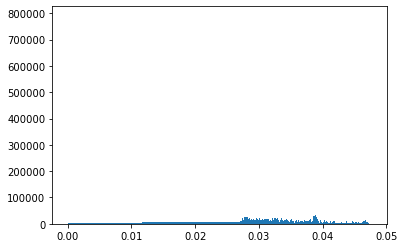

In [32]:
plt.figure()

plt.hist(df_nn['dist'], bins=1000)
plt.show()

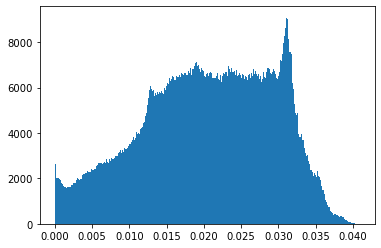

In [33]:
plt.figure()

df_nn_new = df_nn[df_nn['correspondence'] > 0]
plt.hist(df_nn_new['dist'], bins=1000)
plt.show()


Total enriched: 8 / 9000000


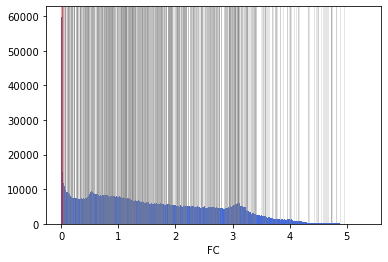

,ligand,receptor,dist,correspondence,FC,p_val,q_val,enriched_rank
COL6A3_CD44,COL6A3,CD44,0.000949,32.110752,0.002881,0.000041,0.008079,1
CTGF_ITGB2,CTGF,ITGB2,0.000987,33.249599,0.003116,0.000046,0.008781,2
MIF_CD74,MIF,CD74,0.001176,41.569546,0.004423,0.000078,0.012740,3
CYR61_ITGB2,CYR61,ITGB2,0.001536,22.179010,0.007545,0.000174,0.022438,4
VCAN_CD44,VCAN,CD44,0.001637,20.863401,0.008567,0.000210,0.025708,5
LAMB1_CD44,LAMB1,CD44,0.001699,19.726011,0.009226,0.000235,0.027853,6
SERPINF1_PLXDC2,SERPINF1,PLXDC2,0.001794,32.503609,0.010289,0.000277,0.031291,7
CCL2_CXCR4,CCL2,CXCR4,0.002133,23.124920,0.014538,0.000464,0.044982,8


In [34]:
df_enriched = chi2_test(df_nn, df=3, pval=0.05, FDR=True, candidates = candidates, plot=True)

df_enriched


Total enriched: 9 / 9000000


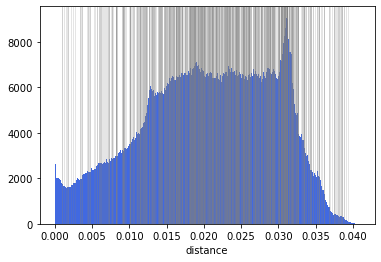

,ligand,receptor,dist,correspondence,p_val,enriched_rank
COL6A3_CD44,COL6A3,CD44,0.000949,32.110752,0.010541,1
CTGF_ITGB2,CTGF,ITGB2,0.000987,33.249599,0.010909,2
MIF_CD74,MIF,CD74,0.001176,41.569546,0.012710,3
CYR61_ITGB2,CYR61,ITGB2,0.001536,22.179010,0.016060,4
VCAN_CD44,VCAN,CD44,0.001637,20.863401,0.016956,5
LAMB1_CD44,LAMB1,CD44,0.001699,19.726011,0.017486,6
SERPINF1_PLXDC2,SERPINF1,PLXDC2,0.001794,32.503609,0.018326,7
CCL2_CXCR4,CCL2,CXCR4,0.002133,23.124920,0.021384,8
APOE_TREM2,APOE,TREM2,0.002463,16.492031,0.024591,9


In [35]:
df_enriched = null_test(df_nn, pct=0.025, candidates=candidates, plot=True)
df_enriched

In [ ]:
# df_enriched.to_excel('Heart.xlsx')

In [ ]:
#check corr

# select = df_nn['correspondence_score'] != 0
# nX = np.asarray(df_nn['correspondence_score'][select])
# nY = np.asarray(df_nn['dist'][select])
# r = np.corrcoef(nX, nY)
# print(r)

# plt.scatter(nX, nY, s=3)
# plt.xlim(0, 100)
# plt.show()

In [36]:
genelist = get_genelist(df_enriched) # saveas='heart_diff'
len(genelist)

15

In [37]:
import gseapy as gp

enr = gp.enrichr(gene_list= genelist,
                 gene_sets= 'BioPlanet_2019', #'GO_Biological_Process_2021',
                 organism='Human', 
                 outdir=None, #'enrichr_kegg',
                 no_plot=True,
                 cutoff=0.05 
                )

In [38]:
enr.results.head(10)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,BioPlanet_2019,Monocyte and its surface molecules,2/11,0.000029,0.002383,0,0,341.470085,3570.560667,ITGB2;CD44
1,BioPlanet_2019,ECM-receptor interaction,3/84,0.000031,0.002383,0,0,61.432099,637.061225,COL6A3;LAMB1;CD44
2,BioPlanet_2019,Pertussis toxin-insensitive CCR5 signaling in ...,2/18,0.000080,0.003082,0,0,192.009615,1811.871284,CXCR4;CCL2
3,BioPlanet_2019,Axon guidance,4/325,0.000081,0.003082,0,0,22.275843,209.834727,CXCR4;COL6A3;LAMB1;TREM2
4,BioPlanet_2019,Interleukin-5 regulation of apoptosis,3/144,0.000156,0.004745,0,0,35.184397,308.394228,ITGB2;CCL2;CD44
5,BioPlanet_2019,Integrin beta-2 pathway,2/29,0.000211,0.005337,0,0,113.720798,962.669308,ITGB2;CYR61
6,BioPlanet_2019,Alpha-M beta-2 integrin signaling,2/41,0.000423,0.007965,0,0,78.682446,611.161366,ITGB2;CTGF
7,BioPlanet_2019,Beta-3 integrin cell surface interactions,2/43,0.000466,0.007965,0,0,74.836773,574.139480,LAMB1;CYR61
8,BioPlanet_2019,Focal adhesion,3/233,0.000640,0.007965,0,0,21.472826,157.900443,ITGB2;COL6A3;LAMB1
9,BioPlanet_2019,Malaria,2/51,0.000655,0.007965,0,0,62.593407,458.833062,ITGB2;CCL2


In [ ]:
# enr.results.to_excel('Heart_enrichr.xlsx')

## mode 'comb':

In [ ]:
obj2 = Xct(ada, 'FB', 'MA_AgP', build_GRN = False, 
           pcNet_name = 'Net_FB2MA_AgP', mode = 'comb', verbose=True)

In [ ]:
w12 = obj2._w[:obj2._net_A.shape[0], obj2._net_A.shape[1]:]

np.mean(w12) 

In [ ]:
projections2, losses2 = obj2.nn_projection(n = 1000, plot_loss = True)

In [ ]:
df_nn2 = obj2.nn_output(projections2)
df_nn2.head()

In [ ]:
#check corr
select = df_nn2['correspondence_score'] != 0
nX = np.asarray(df_nn2['correspondence_score'][select])
nY = np.asarray(df_nn2['dist'][select])
r = np.corrcoef(nX, nY)
print(r)

plt.scatter(nX, nY, s=3)
plt.xlim(0, 100)
plt.show()

In [ ]:
df_nn_filtered2 = obj2.filtered_nn_output(df_nn2, candidates)
df_nn_filtered2.head()

In [ ]:
df_enriched2 = obj2.chi2_test(df_nn2, df = 3, pval = 0.05, FDR = True, candidates = candidates)

df_enriched2

In [ ]:
df_nn_filtered2.loc['MIF_CD74']

## mode pairs:

In [ ]:
obj3 = Xct(ada, 'FB', 'MA_AgP', build_GRN = False, 
           pcNet_name = 'Net_FB2MA_AgP', mode = 'pairs', verbose=True)

In [ ]:
w12 = obj3._w[:obj3._net_A.shape[0], obj3._net_A.shape[1]:]

np.mean(w12) 

In [ ]:
projections3, losses3 = obj3.nn_projection(n = 1000, plot_loss = True)

In [ ]:
df_nn3 = obj3.nn_output(projections3)
df_nn3.head()

In [ ]:
#check corr
select = df_nn3['correspondence_score'] != 0
nX = np.asarray(df_nn3['correspondence_score'][select])
nY = np.asarray(df_nn3['dist'][select])
r = np.corrcoef(nX, nY)
print(r)

plt.scatter(nX, nY, s=3)
plt.xlim(0, 100)
plt.show()

In [ ]:
df_nn_filtered3 = obj3.filtered_nn_output(df_nn3, candidates)
df_nn_filtered3.head()

In [ ]:
df_enriched3 = obj3.chi2_test(df_nn3, df = 3, pval = 0.05, FDR = True, candidates = candidates)

df_enriched3

In [ ]:
df_nn_filtered3.loc['MIF_CD74']